In [ ]:
import pandas as pd
import os
import re
from sklearn.model_selection import train_test_split
import csv
import pandas as pd
import asyncio
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold
from sklearn.model_selection import train_test_split
from dotenv import load_dotenv
from sklearn.metrics import normalized_mutual_info_score


load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")


seven_newsgroups_data = pd.read_csv('fetch_7newsgroups.csv')

def split_train_test(data):
    data = data.dropna(how="any")
    train, test = train_test_split(data, test_size=0.05, random_state=42)

    train = train.sort_values(by='label')
    train_first_doc = train.groupby('label').first().reset_index()

    train_first_doc['div'] = 'train'
    test['div'] = 'test'

    return test, train_first_doc

test_df, instruction_df = split_train_test(seven_newsgroups_data)
test_df["name"] = range(1, len(test_df) + 1)
print(test_df.iloc[5])
print("test Length: ",len(test_df))
print("instruction Length: ", len(instruction_df))
print("original length: ", len(seven_newsgroups_data))


C:\Users\super161\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unnamed: 0                                                    5545
text             From: sp1henhj@edit (Henrik Balthazar Hjort)\n...
label20                                                          5
labels_name20                                       comp.windows.x
label                                                   Technology
div                                                           test
name                                                             6
Name: 5545, dtype: object
test Length:  893
instruction Length:  7
original length:  18846


In [3]:
def make_prompts(bbc_instructions, bbc_data):
    
    prompts = []
    
    # General instructions and fixed texts
    general_instruction = (
        "You are a perfect topic modeling machine. Given a text and the different topics, "
        "you will classify the following text to the correct topic. First you will receive the topics, "
        "afterwards an example and finally the text you have to assign one of the before mentioned topics to."
    )
    topics = "The topics are sport, technology, politics, vehicles, religion, miscellaneous and science. Please make sure, you know the topics and their meaning."
    transition_to_examples = "Now an example for each of the categories will follow."
    transition_to_text_to_classify = (
        "Now the text, you have to classify will follow. Please assess its topic and answer only the topic of it."
    )

    # Iterate through the test DataFrame rows
    for _, test_row in bbc_data.iterrows():
        prompt = general_instruction + "\n" + topics + "\n" + transition_to_examples + "\n"

        # Iterate through instruction DataFrame to add examples
        for _, instruction_row in bbc_instructions.iterrows():
            category = instruction_row['label']
            example_text = instruction_row['text']
            prompt += f"For the following text : \n{example_text}\nThe correct answer would be: {category}\n"

        # Add the actual text to classify from the test set
        text_to_classify = test_row['text']
        prompt += transition_to_text_to_classify + "\n" + text_to_classify + "\n"
        name = f"{test_row['name']}"
        
        prompt_dict = {}
        prompt_dict[name] = prompt
        prompts.append(prompt_dict)
    return prompts            

prompts = make_prompts(instruction_df, test_df)
print(prompts[0])
print(len(prompts))


{'1': 'You are a perfect topic modeling machine. Given a text and the different topics, you will classify the following text to the correct topic. First you will receive the topics, afterwards an example and finally the text you have to assign one of the before mentioned topics to.\nThe topics are sport, technology, politics, vehicles, religion, miscellaneous and science. Please make sure, you know the topics and their meaning.\nNow an example for each of the categories will follow.\nFor the following text : \nFrom: jth@bach.udel.edu (Jay Thomas Hayes)\nSubject: IBM Hardware Forsale\nNntp-Posting-Host: bach.udel.edu\nDitribution: usa\nOrganization: University of Delaware\nLines: 13\n\n\n\n\tI have the following IBM hardware forsale\n\n\tATI VgaWonderXl24 -  This is a great card, it supports 1024x768 256 colors, 800x600 32k colors, and 640x480 16 million colors.  I found that it also speed up windows considerably.  I\'m asking $100 o.b.o. for this card.\n\n\n\tI also have 2 2400 baud mo

In [4]:


async def prompt_llm(prompt):
    semaphore = asyncio.Semaphore(5)
    async with semaphore:
        name = list(prompt.keys())[0]
        promptAI = prompt[name]   

        generation_config = {
        "temperature": 1,
        "top_p": 0.95,
        "top_k": 40,
        "max_output_tokens": 8192,
        "response_mime_type": "text/plain",
        }
        model = genai.GenerativeModel(
        model_name="gemini-1.5-pro",
        generation_config=generation_config,
        safety_settings = {HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
                    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
                    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
                    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE},
        )
        
        chat_session = model.start_chat(
        history=[])
        answer = chat_session.send_message(promptAI)
        text_response = answer._result.candidates[0].content.parts[0].text
        
        return {name : text_response}

In [ ]:
#Organizes the batch processing of the prompts, so thate the API is not overloaded
genai.configure(api_key=GEMINI_API_KEY)
async def prompt_orchestrator():
      batch_size = 5
      avatiables = []
      batches = [prompts[i:i + batch_size] for i in range(0, len(prompts), batch_size)]

      if len(batches[-1]) < batch_size:
            remaining = len(batches[-1])
            batches[-1] = prompts[-remaining:]

      if len(prompts) % batch_size != 0:
            remaining = len(prompts) % batch_size
            batches[-1] = prompts[-remaining:]

      try:
            for batch in batches:
                  avatiables_batch = await asyncio.gather(*(prompt_llm(prompt) for prompt in batch))
                  avatiables.extend(avatiables_batch)
                  print("sleeping")
                  await asyncio.sleep(1)

      except Exception as e:
            print(f"An error occurred: {e}. Returning the accumulated results.")
            return avatiables
      
      return avatiables

results = await prompt_orchestrator()

print(results)


sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
sleeping
s

In [6]:
def add_correct_anser(results, test_df):
    result_with_correct_answer = []
    for result in results:
        for key, value in result.items():
            value = value.replace("\n", "")
            value = value.replace(" \n", "")
            value = value.replace(" ","")
            value = value.replace("*","")
            value = value.lower()
            matching_rows = test_df.loc[test_df['name'] == int(key), 'label']
            if not matching_rows.empty:
                if type(matching_rows.values[0]) == float: 
                    print(f"Nan value", matching_rows.values[0])
                else:
                    category_value = matching_rows.values[0]
                    category_value = category_value.lower()
                    result_with_correct_answer.append({key: (value, category_value)})
            else:
                print(f"No matching category found for key: {key}")
                result_with_correct_answer.append({key: (value, None)})
    return result_with_correct_answer
results_with_correct_answer = add_correct_anser(results, test_df)
print(len(results_with_correct_answer))
print(results_with_correct_answer)

893
[{'1': ('technology', 'science')}, {'2': ('technology', 'technology')}, {'3': ('politics', 'politics')}, {'4': ('vehicles', 'vehicles')}, {'5': ('technology', 'technology')}, {'6': ('technology', 'technology')}, {'7': ('miscellaneous', 'vehicles')}, {'8': ('science', 'technology')}, {'9': ('miscellaneous', 'miscellaneous')}, {'10': ('politics', 'science')}, {'11': ('vehicles', 'vehicles')}, {'12': ('vehicles', 'vehicles')}, {'13': ('vehicles', 'vehicles')}, {'14': ('vehicles', 'vehicles')}, {'15': ('technology', 'technology')}, {'16': ('technology', 'technology')}, {'17': ('politics', 'politics')}, {'18': ('technology', 'technology')}, {'19': ('technology', 'technology')}, {'20': ('vehicles', 'vehicles')}, {'21': ('vehicles', 'vehicles')}, {'22': ('sport', 'sport')}, {'23': ('technology', 'technology')}, {'24': ('sport', 'sport')}, {'25': ('sport', 'sport')}, {'26': ('science', 'science')}, {'27': ('technology', 'technology')}, {'28': ('science', 'science')}, {'29': ('miscellaneous

In [ ]:
#post processing to match answers like "theanswerispolitics" to "politics"

import difflib
from thefuzz import fuzz
def post_process(results):
      
      test_df.loc['result'] = None
      string_list = ["religion", "politics","sport","technology", "vehicles", "science","miscellaneous"]
      final_results = []
      for result in results:
            similarity = []
            for string in string_list:
                  similarity.append([fuzz.partial_ratio(list(result.values())[0][0], string),string])
            max_similarity = max(similarity)
            
            if (max_similarity[0]>60):
                  final_results.append({list(result.keys())[0]: (max_similarity[1], list(result.values())[0][1])})
                  test_df.loc[test_df['name'] == list(result.keys())[0], 'result'] = max_similarity[1]
            else:
                  final_results.append({list(result.keys())[0]: ("", list(result.values())[0][1])})
                  test_df.loc[test_df['name'] == list(result.keys())[0], 'result'] = ""
      
      test_df.to_csv(r"E:\uni\NLP group project\gemini_7newsgroups.csv", index=False)
      return final_results
result_with_correct_answer_pre_post_process = results_with_correct_answer
print(result_with_correct_answer_pre_post_process)
results_with_correct_answer = post_process(results_with_correct_answer)
print(results_with_correct_answer)
print(test_df)

[{'1': ('technology', 'science')}, {'2': ('technology', 'technology')}, {'3': ('politics', 'politics')}, {'4': ('vehicles', 'vehicles')}, {'5': ('technology', 'technology')}, {'6': ('technology', 'technology')}, {'7': ('miscellaneous', 'vehicles')}, {'8': ('science', 'technology')}, {'9': ('miscellaneous', 'miscellaneous')}, {'10': ('politics', 'science')}, {'11': ('vehicles', 'vehicles')}, {'12': ('vehicles', 'vehicles')}, {'13': ('vehicles', 'vehicles')}, {'14': ('vehicles', 'vehicles')}, {'15': ('technology', 'technology')}, {'16': ('technology', 'technology')}, {'17': ('politics', 'politics')}, {'18': ('technology', 'technology')}, {'19': ('technology', 'technology')}, {'20': ('vehicles', 'vehicles')}, {'21': ('vehicles', 'vehicles')}, {'22': ('sport', 'sport')}, {'23': ('technology', 'technology')}, {'24': ('sport', 'sport')}, {'25': ('sport', 'sport')}, {'26': ('science', 'science')}, {'27': ('technology', 'technology')}, {'28': ('science', 'science')}, {'29': ('miscellaneous', '

In [ ]:
#making two lists for the ground truth and the predictions for the evaluation
def extract_ground_truth_and_predictions(results_with_correct_answer):
    ground_truth = []
    predictions = []
    for result in results_with_correct_answer:
        for key, value in result.items():
            ground_truth.append(value[1])
            predictions.append(value[0])
    return ground_truth, predictions
ground_truth, predictions = extract_ground_truth_and_predictions(results_with_correct_answer)


In [9]:
def calculate_NMI(ground_truth, predictions):
    
    nmi_score = normalized_mutual_info_score(ground_truth, predictions)
    print(f"Normalized Mutual Information Score: {nmi_score}")
    return nmi_score


In [ ]:
import numpy as np
from collections import Counter

def calculate_purity(predicted_labels, true_labels):

    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)
    
    unique_clusters = np.unique(predicted_labels)

    total_instances = len(true_labels)
    
    correctly_classified = 0
    for cluster in unique_clusters:

        indices_in_cluster = np.where(predicted_labels == cluster)[0]
        labels_in_cluster = true_labels[indices_in_cluster]
        
        majority_label_count = Counter(labels_in_cluster).most_common(1)[0][1]
        
        correctly_classified += majority_label_count
    
    purity = correctly_classified / total_instances
    print(f"Purity: {purity}")
    return purity





In [ ]:
def calculate_accuracy(predicted_labels, true_labels):

    if len(predicted_labels) != len(true_labels):
        raise ValueError("The length of predicted and true labels must be the same.")
    
    correct_predictions = sum(1 for pred, true in zip(predicted_labels, true_labels) if pred == true)
    
    accuracy = correct_predictions / len(true_labels)
    print(f"Accuracy: {accuracy}")
    return accuracy





In [ ]:
from sklearn.metrics import f1_score
def calculate_f1_score(ground_truth, predictions):

    f1 = f1_score(ground_truth, predictions, average='micro') 
    print(f"F1 Score: {f1}")
    return f1



In [13]:
calculate_NMI(ground_truth, predictions)
calculate_purity(predictions, ground_truth)
calculate_accuracy(predictions, ground_truth)
calculate_f1_score(ground_truth, predictions)

Normalized Mutual Information Score: 0.6686595979501236
Purity: 0.7894736842105263
Accuracy: 0.7894736842105263
F1 Score: 0.7894736842105263


0.7894736842105263

Index(['Unnamed: 0', 'text', 'label20', 'labels_name20', 'label', 'div',
       'name', 'result'],
      dtype='object')
          label                 result
0       science  thetopicistechnology.
1       science                science
2    technology             technology
3      politics               politics
4       science             technology
..          ...                    ...
889    politics                science
890    religion               religion
891  technology             technology
892    politics               religion
893         NaN                    NaN

[894 rows x 2 columns]


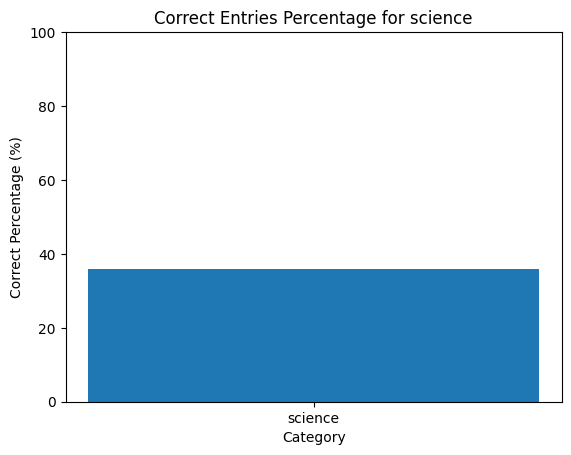

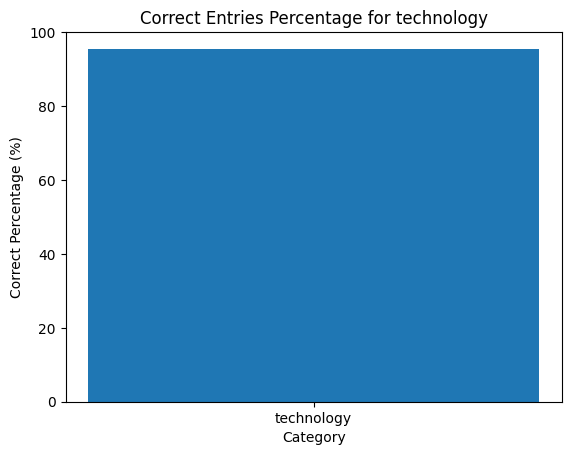

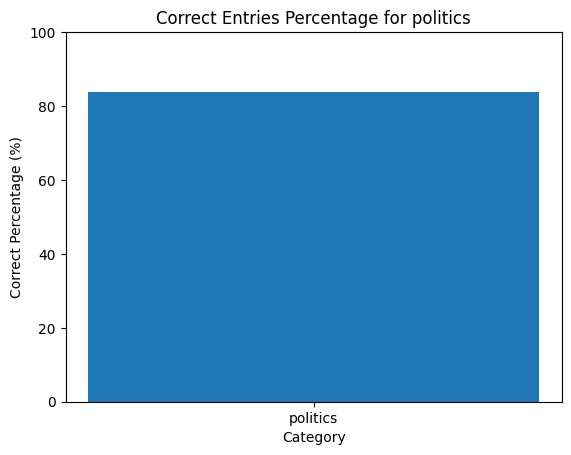

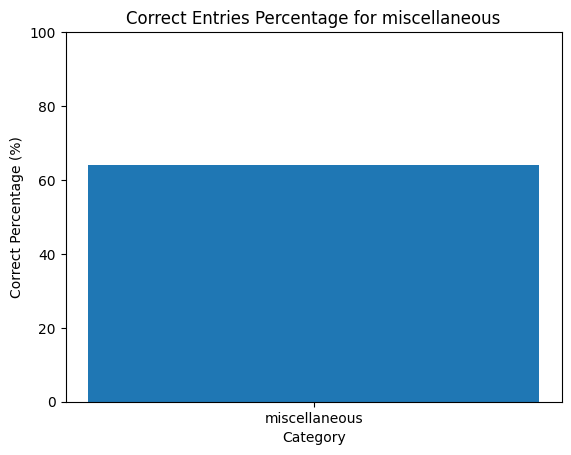

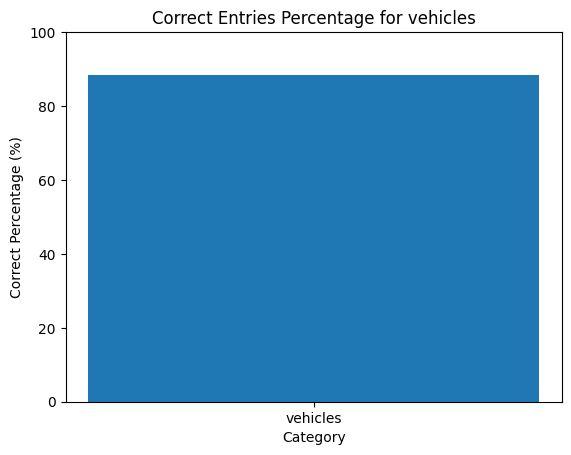

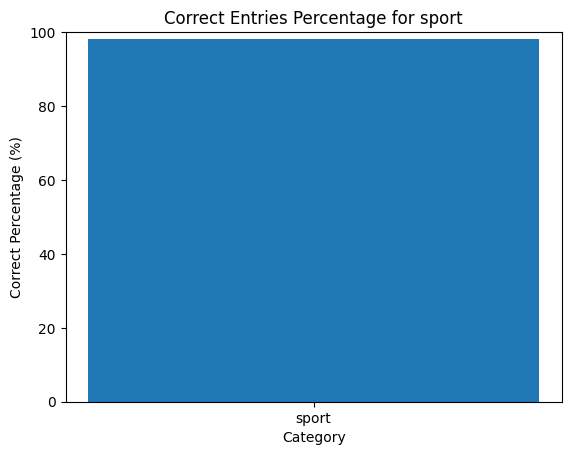

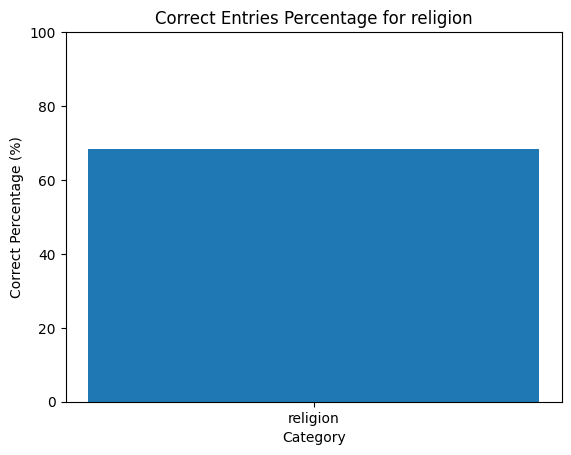

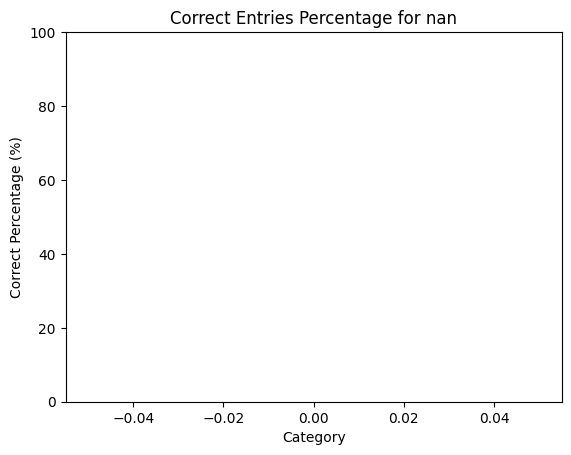

In [ ]:
#plotting the results for better insights
import pandas as pd
import matplotlib.pyplot as plt

def plot_correct_entries_percentage(csv_file):
    df = pd.read_csv(csv_file)

    df['label'] = df['label'].str.lower()

    print(df.columns)
    print(df[['label', 'result']])

    categories = df['label'].unique()

    for category in categories:

        category_df = df[df['label'] == category]

        correct_entries = category_df[category_df['result'] == category]
        correct_percentage = (len(correct_entries) / len(category_df)) * 100 if len(category_df) > 0 else 0

        plt.figure()
        plt.bar([category], [correct_percentage])
        plt.xlabel('Category')
        plt.ylabel('Correct Percentage (%)')
        plt.title(f'Correct Entries Percentage for {category}')
        plt.ylim(0, 100)
        plt.show()

plot_correct_entries_percentage(r'C:\Users\super161\Desktop\import barchart\gemini_7newsgroups_original.csv')
